In [1]:
%load_ext itikz
import itikz
if False : from itikz import nicematrix_dev as nM
else:      from itikz import nicematrix as nM

import sympy as sym

import jinja2

import panel as pn ; pn.extension()
import holoviews as hv; hv.extension('bokeh')
import numpy as np
import sympy as sym

import os
import tempfile
from pathlib import Path

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

np.random.seed(112244)

# Gaussian Elimination Type Algorithms

In [2]:
def gen_matrix(m,n, low=1,high=9):
    return np.random.randint( low=low,high=high, size=(m,n))

def gen_cx_matrix(m,n, low=1,high=9):
    return    np.random.randint( low=low,high=high, size=(m,n))+\
           1j*np.random.randint( low=low,high=high, size=(m,n))


A0 = None;             A1 = gen_matrix(2,3); A2=gen_matrix(3,2);   A3=gen_matrix(2,1)
B0 = gen_matrix(2,2);  B1 = B0 @ A1;         B2= B1 @ A2;          B3=B2 @ A3
#C0 = gen_matrix(1,2);  C1 = C0 @ B1;         C2= C1 @ B2

#      -   (2,3) (3,2)   => COLS:  2 3 2
#    (2,2) (2,3) (2,2)   => ROWS:  3 2

layers=[ [A0, A1, A2, A3],
         [B0, B1, B2, B3],
       ]

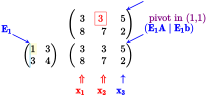

In [3]:
A0 = None;  A1 = gen_matrix(2,3); A2=gen_matrix(2,2)
layers=[ [A0, A1], [A2, A1]]
h,m = nM.ge( layers, Nrhs=[0],
             formater = sym.latex,
             pivot_list=[ [(0,1), [(0,1)] ]  ],
             bg_for_entries = [[1,0, [(0,0)], 'yellow!15', 1], ],
             ref_path_list = [ [1,0, [(0,0)   ],'vv','cyan'],
                             ],
             comment_list = ["pivot in (1,1)",],
             variable_summary = [True,True,False],
             array_names = ['E', ['A', 'b']],
             tmp_dir="tmp", keep_file="tmp/m3"
)
h

In [4]:
!ls tmp
!rm tmp/*

ep.aux
ep.fdb_latexmk
ep.fls
ep.log
ep.svg
ep.tex
ge_1056676208930c2b206551d7d59c487d.svg
ge_1056676208930c2b206551d7d59c487d.tex
m3.svg
m3.tex


## MatrixGridLayout

In [5]:
#%load itikz/nicematrix.py

| | | | |
| --- | --- | --- | --- |
|     |       | y y |   |
|     | x x x | y y |z |
|     | x x x | y y |z |
| a a | * * * | * * |# |
| a a | * * * | * * |# |

In [6]:
def testMatrixGridLayout():
    A0 = None;             A1 = gen_matrix(4,5);
    B0 = gen_matrix(4,4);  A2 = B0 @ A1;
    B1 = gen_matrix(4,4);  A3 = B1 @ A2;

    layers = [[ A0, A1], [B0, A2], [B1, A3]]
    mm = nM.MatrixGridLayout(layers, extra_cols=[1,3,2], extra_rows=[0,0,0,2])
    mm.describe()
    print()
    #print( 'no partition:', MatrixGridLayout.matrix_array_format( 5 ))
    #print( 'partition:   ', MatrixGridLayout.matrix_array_format( 5, vpartitions=[1,3,4] ))
    #print()
    print('Top Left : Bottom Right Corners')
    for i in range(mm.nGridRows):
        for j in range(mm.nGridCols):
            tl,br,_ = mm._top_left_bottom_right(i,j)
            print( f"  {tl}:{br}", end='')
        print()
    # ====================================================================
    # Process the Matrix Grid for Display
    # ====================================================================
    mm.array_format_string_list( partitions={ 1:[2], 2:[1], 3:[1]}, spacer_string=r'@{\hspace{5mm}}' )
    mm.array_of_tex_entries()
    mm.nm_submatrix_locs()

    if True:
        red   = nM.make_decorator( text_color='red' )    
        boxbf = nM.make_decorator( boxed=True, bf=True, text_color='red')
        bg    = nM.make_decorator( text_bg="red!15")

        mm.decorate_tex_entries( 0,3, red,   entries=None )
        mm.decorate_tex_entries( 1,2, boxbf, entries= [(1,0),(0,1)])
        mm.decorate_tex_entries( 1,1, bg,    entries=[(0,0),(1,1)] )

    #mm.decorate_tex_entries( 1,2, lambda a: '\\boxed{{ {a} }}'.format(a=a), entries= [(1,0),(0,1)])

    mm.tex_repr( blockseps = r'[3mm]') # r'\noalign{\vskip2mm} ')

    # ====================================================================

    print("% -------------------------------------")
    print(f"format: {mm.format}");
    print("% -------------------------------------")
    print("LaTeX representation of the matrix")
    for l in mm.tex_list:
        print(l)
    print("% -------------------------------------")
    print("Submatrices:", mm.locs )
    print("% -------------------------------------")

    return mm

## Example mX: Single Matrix, Extra Rows

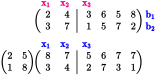

In [7]:
mX = nM.MatrixGridLayout([[None, gen_matrix(2,6)],[gen_matrix(2,2), gen_matrix(2,6)]], extra_cols=1, extra_rows=[1,1,0])
#    extra_cols: add another column at the end
#    extra_rows: add a row above, a row in the middle, no row at the end
mX.array_format_string_list( partitions={ 1:[2,1]}, spacer_string=r'@{\hspace{5mm}}', last_col_format=r'l@{\hspace{2.5cm}}' )
mX.array_of_tex_entries()

# add some info in each of the extra rows
mX.add_row_above(0,1,['x_1','x_2','x_3'], formater = lambda a: '\\color{{magenta}}{{\\mathbf{{ {a} }}}}'.format(a=a))
mX.add_row_below(0,1,['x_1','x_2','x_3'], formater = lambda a: '\\color{{blue}}{{\\mathbf{{ {a} }}}}'.format(a=a))

# add some info in each of the extra columns
mX.add_col_right(0,1,['b_1','b_2'], formater = lambda a: '\\color{{blue}}{{\\mathbf{{ {a} }}}}'.format(a=a))

mX.nm_submatrix_locs()

mX.tex_repr( blockseps = r'[2mm]')
mX_code = mX.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        mX_code, prefix='mX_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="tmp/mX" )
h

## Example m1

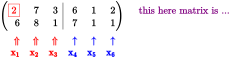

In [8]:
m1 = nM.MatrixGridLayout(gen_matrix(2,6), extra_cols=1, extra_rows=2)
m1.array_format_string_list( partitions={ 1:[3]}, spacer_string=r'@{\hspace{5mm}}' )
m1.array_of_tex_entries()
m1.decorate_tex_entries( 0,1, lambda a: '\\color{{red}}{{ \\boxed{{{a}}} }}'.format(a=a), entries=[(0,0)] )

blue = nM.make_decorator(text_color='blue', bf=True)
red  = nM.make_decorator(text_color='red',  bf=True)

typ = [red(r'\Uparrow'),red(r'\Uparrow'),red(r'\Uparrow'),blue(r'\uparrow'),blue(r'\uparrow'),blue(r'\uparrow')]
var = [red('x_1'),      red('x_2'),      red('x_3'),      blue('x_4'),      blue('x_5'),      blue('x_6')]

m1.add_row_below(0,1,typ, formater=lambda a: a )
m1.add_row_below(0,1,var, offset=1, formater=lambda a: a )

m1.nm_text( ['this here matrix is ...'])
m1.nm_submatrix_locs()
m1.tex_repr( blockseps = r'\noalign{\vskip2mm} ')

m1_code = m1.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        m1_code, prefix='m1_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="tmp/m1" )
h

## Example m2

In [9]:
m2=testMatrixGridLayout()

Layout 3 x 2 grid:
.  insert extra_cols:            [1, 3, 2]
.  col_start                   = [ 1  8 15]
.  row_start                   = [ 0  4  8 14]

Consistent Matrix Sizes in the grid
  (4, 4)  (4, 5)
  (4, 4)  (4, 5)
  (4, 4)  (4, 5)
Actual TopLeft:BottomRight Indices
  (4, 5):(3, 4)  (0, 8):(3, 12)
  (4, 1):(7, 4)  (4, 8):(7, 12)
  (8, 1):(11, 4)  (8, 8):(11, 12)

Top Left : Bottom Right Corners
  (4, 5):(3, 4)  (0, 8):(3, 12)
  (4, 1):(7, 4)  (4, 8):(7, 12)
  (8, 1):(11, 4)  (8, 8):(11, 12)
% -------------------------------------
format: r@{\hspace{5mm}}rrrr@{\hspace{5mm}}rrr@{\hspace{5mm}}rrIrrr@{\hspace{5mm}}rl@{\hspace{2cm}}
% -------------------------------------
LaTeX representation of the matrix
 &  &  &  &  &  &  &  & 8 & 2 & 8 & 7 & 5 &  &  \\
 &  &  &  &  &  &  &  & 2 & 2 & 7 & 2 & 8 &  &  \\
 &  &  &  &  &  &  &  & 6 & 4 & 6 & 7 & 6 &  &  \\
 &  &  &  &  &  &  &  & 5 & 7 & 1 & 5 & 6 &  &  \\m]
 & 2 & 3 & 8 & 7 &  &  &  & \Block[draw=black,fill=red!15]{}{105} & 91 & 9

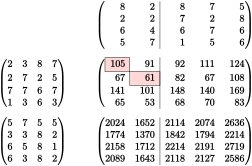

In [10]:
m2_latex_doc = m2.nm_latexdoc(template = nM.GE_TEMPLATE )

h = itikz.fetch_or_compile_svg(
        m2_latex_doc, prefix='tst_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=1, keep_file="tmp/m2" )
h

## Example m3

In [11]:
k  = sym.Symbol('k'); h = sym.Symbol('h')
Ab = sym.Matrix([[1,2,4,1],[2,k,8,h],[3,7,3,1]]); matrices = [[None, Ab]]; pivots = []; txt=[]
# we could use row ops, but we want a computational layout (and hence the E matrices!):
#    A=A.elementary_row_op('n->n+km', k=-3, row1=2,row2=0 );A
#    A=A.elementary_row_op('n<->m',row1=1,row2=2);A

E1=sym.eye(3);E1[1:,0]=[-2,-3]; A1=E1*Ab;                               matrices.append([E1,A1]); pivots.append((1,1));txt.append('Pivot at (1,1)')
E2=sym.eye(3);E2=E2.elementary_row_op('n<->m',row1=1,row2=2); A2=E2*A1; matrices.append([E2,A2]); pivots.append(None); txt.append('Rows 2 <-> 3')
E3=sym.eye(3);E3[2,1]=4-k; A3=E3*A2;                                    matrices.append([E3,A3]); pivots.append((2,2));txt.append('Pivot at (2,2)')
pivots.append((3,3)); txt.append('In Row Echelon Form')

if False:
    mat_rep, submatrix_locs, pivot_locs, path_corners, txt_with_locs,mat_format = \
       nM.ge_layout( matrices, Nrhs=1, pivots=pivots, txt=txt, decorate=True,\
                     formater=lambda x: sym.latex(x))

    mat_options = r"""[ code-before =
        {
        % ----------------------------------------------------------------------- Row-echelon form Path
        \tikz \draw[red] """ + " -- ".join( path_corners )+ " ; } ]"

    h =\
    itikz.fetch_or_compile_svg( jinja2.Template( nM.GE_TEMPLATE ).render( preamble=nM.preamble, extension=nM.extension,
                                                                          mat_rep=mat_rep, mat_format=mat_format, mat_options=mat_options,
                                                                          submatrix_locs=submatrix_locs, pivot_locs=pivot_locs, txt_with_locs=txt_with_locs),
                                prefix='sol_rhs_', working_dir='/tmp/itikz', debug=False,
                                **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True), nexec=4, keep_file="/tmp/foo" )
    display(h)

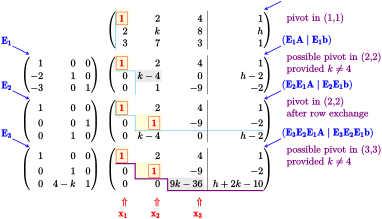

In [12]:
# note the top annotation is not properly displayed. TODO: add mode space above when cropping the SVG
h,m = nM.ge( matrices, Nrhs=[1],
             formater = sym.latex,
             pivot_list=[ [(0,1), [(0,0)] ],
                          [(1,1), [(0,0)]],   # ,(1,1)
                          [(2,1), [(0,0),(1,1)]],
                          [(3,1), [(0,0),(1,1)]] # ,(2,2)
                          ],
             bg_for_entries = [[0,1, [(0,0)],             'yellow!15', 1],
                               [1,1, [(0,0)            ], 'yellow!15', 1],
                               [1,1, [      (1,1)      ], 'gray!15', 1],
                               [2,1, [(0,0),(1,1)      ], 'yellow!15', 1],
                               [3,1, [(0,0),(1,1),(2,2)], 'yellow!15', 1],
                               [3,1, [(2,2)],             'gray!15', 1],
                              ],
             ref_path_list = [ [0,1, [(0,0)            ],'vv','cyan'],
                               [1,1, [(0,0),(1,1)      ],'hv','cyan'],
                               [2,1, [(0,0),(1,1)      ],'vh','cyan'],
                               [3,1, [(0,0),(1,1),(2,2)],'hh']
                             ],
             comment_list = ["pivot in (1,1)",
                             r"possible pivot in (2,2) \\ \qquad provided $k \ne 4$",
                             r"pivot in (2,2)\\ \qquad after row exchange",
                             r"possible pivot in (3,3) \\ \qquad provided $k \ne 4$"],
             variable_summary = [True,True,True],
             array_names = ['E', ['A', 'b']],
             tmp_dir="tmp", keep_file="tmp/m3"
)
h

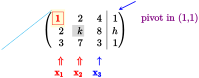

In [13]:
# There is also a problem with the leftmost path in a single matrix
# TODO track down if it is itikz or nicematrix code
foo= [matrices[0]]
h,mm = nM.ge( foo, Nrhs=[1],
             formater = sym.latex,
             pivot_list=[ [(0,1), [(0,0)] ]
                          ],
             bg_for_entries = [[ [0,1, [(0,0)],             'yellow!15', 1], [0,1, [(1,1)],             'black!15', 1]],
                              ],
             ref_path_list = [ [0,1, [(0,0)            ],'vv','cyan'],
                             ],
             comment_list = ["pivot in (1,1)",],
             variable_summary = [True,True,False],
             array_names = ['E', ['A', 'b']],
             tmp_dir="tmp", keep_file="tmp/m3"
)
h

In [14]:
# We can use m to add additional decorations before converting to an SVG
m.rowechelon_paths=[]
m.submatrix_name = 'A'

def nm_add_rowechelon_path( self, gM,gN, pivots, case='hh', color='red' ):
        tl,_,shape = self._top_left_bottom_right( gM, gN )
        
        # --------------------------------------------- # add the end point
        if (case=='vh') or (case=='hh'):                #   last dir: ->
            pivots.append( (pivots[-1][0]+1,shape[1]))  #     we end in current row+1, last col
        else:                                           #   last dir: |
            pivots.append( (shape[0],pivots[-1][1]))    #     we end in current col, last row

        # --------------------------------------------- # obtain the corner positions
        if (case == 'vh') or (case == 'vv'):            # first motion is vertical: go down 1 row
            cur = pivots[0]                             #   since we move vertically, start at cur north east
        else:                                           # first move is horizontal
            cur = (pivots[0][0]+1, pivots[0][1])        #   since we move horizontally, start at cur south east

        ll  = [ cur ]           
        for nxt in pivots[1:]:
            if nxt[1] != cur[1]:                        # next entry is in  a different column: first go down to its row
                ll.append( (nxt[0],cur[1]) )
            ll.append( nxt )                            # now move horizontally to this entry
            cur = nxt

        # --------------------------------------------- # generate the tikz command
        if (case=='vh') or (case=='hh'):                #   last dir: ->
            i,j = ll[-2]
            pos = f'let \\p1 = ({self.submatrix_name}{gM}x{gN}.south east), \\p2 = ({i+tl[0]+1}-|{j+tl[1]+1}) in '
            end =  r' -- (\x2,\y1) -- (\x1,\y1);'
            ndx = -2
        else:                                           #   last dir: |
            i,j = ll[-1]
            pos = f'let \\p1 = ({self.submatrix_name}{gM}x{gN}.south west), \\p2 = ({i+tl[0]+1}-|{j+tl[1]+1}) in '
            end = r' -- (\x2,\y1);'
            ndx = -1

        cmd = '\\tikz \\draw['+color+']    ' + pos + ' -- '.join( [f'({i+tl[0]+1}-|{j+tl[1]+1})' for (i,j) in ll[:ndx]]) + end
        self.rowechelon_paths.append( cmd )

m.nm_add_rowechelon_path( 0,1, [(0,0)            ],'vv','blue,line width=0.6mm')
m.nm_add_rowechelon_path( 1,1, [(0,0),(1,1)      ],'hv','blue,line width=0.6mm')
m.nm_add_rowechelon_path( 2,1, [(0,0),(1,1)      ],'vh','cyan,line width=0.6mm')
m.nm_add_rowechelon_path( 3,1, [(0,0),(1,1),(2,2)],'hh','blue,line width=0.6mm')

for tikz in m.rowechelon_paths: print(tikz)

\tikz \draw[blue,line width=0.6mm] let \p1 = (A0x1.north west), \p2 = (A0x1.south east), \p3 = (4-|4), \p4 = (4-|4) in (\x1,\y1) -- (\x4,\y2);
\tikz \draw[blue,line width=0.6mm] let \p1 = (A1x1.north west), \p2 = (A1x1.south east), \p3 = (5-|4), \p4 = (7-|5) in (\x1,\y3) -- ($ (5-|5) + (0.1,0) $) -- ($ (\x4,\y2) + (0.1,0) $);
\tikz \draw[cyan,line width=0.6mm] let \p1 = (A2x1.north west), \p2 = (A2x1.south east), \p3 = (8-|4), \p4 = (9-|5) in (\x1,\y1) -- (\x1,\y3) -- ($ (8-|5) + (0.1,0) $) -- ($ (9-|5) + (0.1,0) $) -- (\x2,\y4);
\tikz \draw[blue,line width=0.6mm] let \p1 = (A3x1.north west), \p2 = (A3x1.south east), \p3 = (11-|4), \p4 = (13-|6) in (\x1,\y3) -- ($ (11-|5) + (0.1,0) $) -- ($ (12-|5) + (0.1,0) $) -- ($ (12-|6) + (0.1,0) $) -- ($ (\x4,\y2) + (0.1,0) $) -- (\x2,\y2);


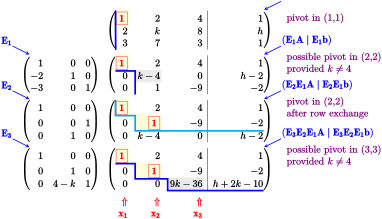

In [15]:
m_code = m.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
    m_code, prefix='ge_', working_dir="tmp", debug=False,
    **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
    nexec=1, keep_file='tmp/tst' )
h

# Fancy QR Example

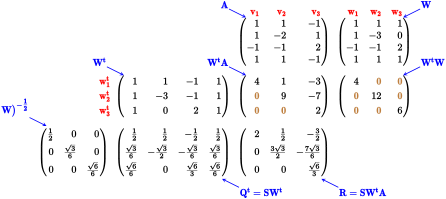

In [16]:
A = sym.Matrix([[ 1,  1, -1],
                [ 1, -2,  1],
                [-1, -1,  2],
                [ 1,  1, -1]])
W = sym.Matrix([[ 1,  1,  1],
                [ 1, -3,  0],
                [-1, -1,  2],
                [ 1,  1,  1]])

WtW  = W.T @ W
WtA  = W.T @ A
S    = WtW**(-1)
for i in range(S.shape[0]):
    S[i,i]=sym.sqrt(S[i,i])

Qt = S*W.T
R  = S*WtA

matrices =  [ [ None,  None,   A,    W ],
              [ None,   W.T, WtA,  WtW ],
              [ S,       Qt,   R, None ] ]

def nM_qr(matrices, formater=repr , array_names=True, scale=0.5, tmp_dir=None, keep_file=None):
    mZ = nM.MatrixGridLayout( matrices, extra_rows = [1,0,0,0])

    mZ.array_format_string_list()
    mZ.array_of_tex_entries(formater=formater)

    brown    = nM.make_decorator(text_color='brown', bf=True )
    def qr_dec_known_zeros( WtA, WtW ):
        l_WtA = [(1,2), [(i,j) for i in range(WtA.shape[0]) for j in range(WtA.shape[0]) if i >  j ]]
        l_WtW = [(1,3), [(i,j) for i in range(WtW.shape[0]) for j in range(WtW.shape[0]) if i != j ]]
        return  [l_WtA, l_WtW]

    for spec in qr_dec_known_zeros(WtA, WtW):
        #[ [(1,2), [(1,0),(2,0),(2,1)]], [(1,3), [(1,0),(2,0),(2,1), (0,1),(0,2),(1,2)]] ]:
        mZ.decorate_tex_entries( *spec[0], brown, entries=spec[1] )

    red      = nM.make_decorator(text_color='red',  bf=True)
    red_rgt  = nM.make_decorator(text_color='red',  bf=True, move_right=True)
    mZ.add_row_above(0,2, [red(f'v_{i+1}')   for i in range(3)] + [red(f'w_{i+1}') for i in range(3)], formater= lambda a: a )
    mZ.add_col_left( 1,1, [red_rgt(f'w^t_{i+1}') for i in range(3)], formater= lambda a: a )

    if array_names:
        dec = nM.make_decorator(bf=True, delim='$')
        mZ.nm_submatrix_locs( 'QR', color='blue', name_specs=[
            [(0,2), 'al', dec('A')],
            [(0,3), 'ar', dec('W')],
            # ----------------------
            [(1,1), 'al', dec('W^t')],
            [(1,2), 'al', dec('W^t A')],
            [(1,3), 'ar', dec('W^t W')],
            # ----------------------
            [(2,0), 'al', dec(r'S = \left( W^t W \right)^{-\tfrac{1}{2}}')],
            [(2,1), 'br', dec(r'Q^t = S W^t')],
            [(2,2), 'br', dec('R = S W^t A')]
        ] )
    else:
        mZ.nm_submatrix_locs()

    mZ.tex_repr( blockseps = r'\noalign{\vskip3mm} ')

    mZ.preamble = nM.preamble + r" \NiceMatrixOptions{cell-space-limits = 2pt}"
    mZ_code = mZ.nm_latexdoc( fig_scale=scale )

    h = itikz.fetch_or_compile_svg(
            mZ_code, prefix='qr_', working_dir=tmp_dir, debug=False, scale=0.8,
            **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
            nexec=1, keep_file=keep_file )
    return h, mZ

#h,mz = nM.qr( matrices, formater=lambda x: '{0:.8f}'.format(float(x)), array_names=True, fig_scale=0.7, tmp_dir="/tmp", keep_file='/tmp/qr')
h,mz = nM.qr( matrices, formater=sym.latex, array_names=True, tmp_dir="/tmp", keep_file='/tmp/qr_fancy')
h

# Matrix Stacks

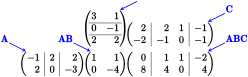

In [17]:
A   = np.array( [[-1,2,2],[2,0,-3]])
B   = np.array( [[3,1],[0,-1],[2,2]])
C   = np.array( [[2,2,1,-1],[-2,-1,0,-1]])
AB  = A @ B
ABC = AB @ C

matrices=[[None, B, C],[A, AB, ABC]]
m_lr = nM.MatrixGridLayout(matrices, extra_cols=1, extra_rows=2)
m_lr.array_format_string_list( spacer_string=r'@{\hspace{5mm}}', last_col_format=r'l@{\hspace{2.0cm}}',
                              partitions={2:[1,3]},
                             )
m_lr.array_of_tex_entries()

dec = nM.make_decorator(bf=True, delim='$')
m_lr.nm_submatrix_locs( 'PROD', color='blue', name_specs=[
            [(0,1), 'ar', dec('B')],
            [(0,2), 'ar', dec('C')],
            # ----------------------
            [(1,0), 'al', dec('A')],
            [(1,1), 'al', dec('A B')],
            [(1,2), 'ar', dec('A B C')],
        ],
        line_specs = [
            [(0,1), [1,2], None],
            [(1,0), None, [1,2]]
        ]
        )

def foo(m):
    m.preamble = r'\tikzset{highlight/.style = { fit = #1 , fill=red!15, inner sep = 2pt } } %' +\
                 '\n' #+\
                 #r'\tikzset{erase/.style = { fit = #1 , fill=Olive!90!Fuchsia, inner sep = 2pt } }'
    m.codebefore.append( f'\\tikz \\node [highlight = (2-5)] {{ }} ;')
    for k in ['(4-1) (4-3)','(5-3)', '(1-5) (3-5)']:
        m.codebefore.append( f'\\tikz \\node [highlight = {k}] {{ }} ;')
    #for k in ['(2-9) (3-9)','(4-9) (5-9)', '(4-4) (5-4)']:
    #    m.rowechelon_paths.append( f'\\node [erase = {k}] {{ }} ;')

    #dark = nM.make_decorator(text_color='Brown4',  bg_color='Green4!60')
#    m.codebefore.append(r'''\cellcolor{red!15}{1-6,2-9,2-12,3-11} ''')
#    m.codebefore.append(r'''\columncolor{blue!15}{3} ''')
#    m.decorate_tex_entries( 0,1, dark, entries=[(0,1),(1,1),(2,1)])
#    m.decorate_tex_entries( 1,0, dark, entries=[(0,0),(0,1),(0,2)])
#m_lr.apply(foo)
#foo(m_lr)
#m_lr.nm_background( ['(4-1) (4-3)','(5-3)', '(1-5) (3-5)'], color='blue!30' )
#m_lr.nm_background( ['(2-6) (3-9)'], style_name='redbg', color='red!15' )
#m_lr.nm_background( ['(2-9) (3-9)','(4-9) (5-9)', '(4-4) (5-4)'], style_name='erase', color='black!30' )

#m_lr.nm_background( 0,1, [(0,0),[(0,1),(2,1)]], color='blue!30', style_name='style_blue')
#m_lr.nm_background( 0,2, [[(0,0), (0,3)]],      color='red!15',  style_name='style_red')
#m_lr.nm_background( 1,0, [[(0,0), (0,2)]],      color='black!30',style_name='erase')
#m_lr.nm_background( 1,1, [[(0,0), (0,1)]],      color='black!30',style_name='erase')
#m_lr.nm_background( 1,2, [[(0,0), (0,3)]],      color='black!30',style_name='erase')

m_lr.tex_repr() # blockseps = r'\noalign{\vskip2mm} ')

m_lr_code = m_lr.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        m_lr_code, prefix='abc_',
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=1,debug=False, working_dir="tmp", keep_file="tmp/abc_lr_pb" )
h

entry: (1, 0)
entry: [(0, 0), (1, 3)]
entry: [(0, 0), (1, 0)]
entry: (1, 1)
['(4-1)', '(5-1)', '(5-2)']


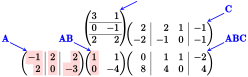

In [18]:
def _mk_entries( self, gM, gN, *args ):
    tl,_,_ = self._top_left_bottom_right( gM, gN )

    def mk(entry):
        print('entry:', entry)
        if not isinstance( entry, list):
            return [f'({tl[0]+entry[0]+1}-{tl[1]+entry[1]+1})']
        i1,j1 = entry[0]
        i2,j2 = entry[-1]

        return [f'({tl[0]+i+1}-{tl[1]+j+1})' for i in range(i1,i2+1) for j in range(j1,j2+1)]

    l = [mk(entry) for entry in args]
    return [loc for sublist in l for loc in sublist]

def nm_background( self, gM, gN, entries, style_name='highlight', color='red!15' ):
    if style_name not in self.stylenames:
        self.stylenames.append( style_name )
        self.preamble = self.preamble + r'\tikzset{' + style_name + f'/.style = {{ fit = #1 , fill={color}, inner sep = 2pt }} }} %' + '\n'
    for entry in entries:
        for k in _mk_entries(self, gM,gN, entry):
            self.codebefore.append( f'\\tikz \\node [{style_name} = {k}] {{ }} ;')

def foo(*args):
    for arg in args:
        print(arg)
#foo([(0,0), (1,1)])
m_lr.stylenames=[]
nm_background( m_lr, 1,0, [ (1,0), [(0,0), (1,3)]] )
print( _mk_entries( m_lr, 1,0, [(0,0), (1,0)], (1,1)) )
#_mk_entries( m_lr, 1,0, (1,1), (1,2), [(2,1),(3,2)])

m_lr_code = m_lr.nm_latexdoc()

if True:
    h = itikz.fetch_or_compile_svg(
    m_lr_code, prefix='m_lr_', working_dir="tmp", debug=False,
    **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
    nexec=1, keep_file="tmp/m_lr" )
h

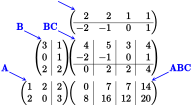

In [19]:
A = np.array( [[1,2,2],[2,0,3]])
B = np.array( [[3,1],[0,1],[2,2]])
C = np.array( [[2,2,1,1],[-2,-1,0,1]])
AB  = A @ B
ABC = AB @ C

matrices=[[None,C],[B, B@C], [A,ABC]]
m_td = nM.MatrixGridLayout(matrices, extra_cols=1, extra_rows=2)
m_td.array_format_string_list( spacer_string=r'@{\hspace{5mm}}',
                               last_col_format=r'l@{\hspace{2cm}}' )
m_td.array_of_tex_entries()

#m_td.add_horizontal_partition( 0,1,0,  (0,3))
#m_td.add_horizontal_partition( 1,1,1,  (0,3))

dec = nM.make_decorator(bf=True, delim='$')
m_td.nm_submatrix_locs( 'PROD', color='blue', name_specs=[
            [(0,1), 'al', dec('C')],
            # ----------------------
            [(1,0), 'al', dec('B')],
            [(1,1), 'al', dec('B C')],
            [(2,0), 'al', dec('A')],
            [(2,1), 'ar', dec('A B C')],
        ] ,
        line_specs = [
            [(0,1), 1, None],
            [(1,0), None, 1], [(1,1), 2,[1,2,3]],
            [(2,0), None, 2], [(2,1),None,[1,2,3]]
        ]
        )
m_td.tex_repr(blockseps = r'[2mm]') # blockseps = r'\noalign{\vskip2mm} ')
#m_td.add_horizontal_partitions( [[0,2,0,[0,4]] ])

m_td_code = m_td.nm_latexdoc()

if True:
    h = itikz.fetch_or_compile_svg(
    m_td_code, prefix='m_td_', working_dir="tmp", debug=False,
    **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
    nexec=1, keep_file="tmp/abc_td" )
h

In [20]:
itikz.build_commands_dict(use_xetex=True,use_dvi=True,crop=True)

{'tex_program': ['latexmk', '-quiet', '-silent', '-xelatex'],
 'svg_converter': [['dvisvgm', '--font-format=woff2', '--exact'], '.xdv'],
 'svg_crop': ['inkscape',
  '--batch-process',
  '--export-plain-svg',
  '-D',
  '--export-margin=1',
  '-o']}

# Eigenproblem Tables

## Use itikz directly

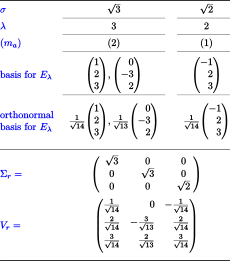

In [21]:
%%itikz --template standalone --tex-packages=booktabs,mathtools,nicematrix,xcolor --use-xetex --keep-file ./tmp/ep --temp-dir
% --debug 
\begin{tabular}{@{}lccc@{}} \toprule
$\color{blue}{\sigma}$ & $\sqrt{3}$ & & $\sqrt{2}$   \\ \cmidrule{2-2} \cmidrule{4-4}
$\color{blue}{\lambda}$ & $3$ & & $2$                \\ \cmidrule{2-2} \cmidrule{4-4}
$\color{blue}{\left( m_a \right)}$ & $(2)$ & & $(1)$ \\ \cmidrule{2-2} \cmidrule{4-4} \addlinespace[1mm]
% ------------------------------------------------------------- eigenvectors
{\parbox{2cm}{\textcolor{blue}{basis for $\color{blue}{E_\lambda}$}}} & $\begin{pNiceArray}{r} 1 \\2\\3 \end{pNiceArray},
                           \begin{pNiceArray}{r} 0 \\ -3 \\ 2 \end{pNiceArray}$
                        & & $\begin{pNiceArray}{r} -1 \\2\\3 \end{pNiceArray}$ \\  \cmidrule{2-2} \cmidrule{4-4}  \addlinespace[2mm]
% ------------------------------------------------------------- orthonormal eigenvectors
{\parbox{2cm}{\textcolor{blue}{orthonormal basis for $E_\lambda$}}} & $\frac{1}{\sqrt{14}}\begin{pNiceArray}{r} 1 \\2\\3 \end{pNiceArray},
                           \frac{1}{\sqrt{13}}\begin{pNiceArray}{r} 0 \\ -3 \\ 2 \end{pNiceArray}$
                        & & $\frac{1}{\sqrt{14}}\begin{pNiceArray}{r} -1 \\2\\3 \end{pNiceArray}$ \\ \addlinespace[1mm]
 \addlinespace[2mm] \midrule \addlinespace[2mm]
% ------------------------------------------------------------- lambda
$\color{blue}{\Sigma_r =}$ & \multicolumn{3}{c}{
    $\begin{pNiceArray}{c@{\hspace{8mm}}c@{\hspace{8mm}}c}
                      \;\; \sqrt{3}  &                    0 &                    0 \;\; \\
                      \;\;        0  &             \sqrt{3} &                    0 \;\; \\
                      \;\;        0  &                    0 &             \sqrt{2} \;\; \\ \end{pNiceArray}$} \\ \addlinespace[2mm]
% ------------------------------------------------------------- Q
$\color{blue}{V_r = }$ & \multicolumn{3}{c}{ $ \begin{pNiceArray}{rrr}
                  \frac{1}{\sqrt{14}} &                    0 & -\frac{1}{\sqrt{14}} \\[2mm]
                  \frac{2}{\sqrt{14}} & -\frac{3}{\sqrt{13}} &  \frac{2}{\sqrt{14}} \\[2mm]
                  \frac{3}{\sqrt{14}} &  \frac{2}{\sqrt{13}} &  \frac{3}{\sqrt{14}} \\[2mm]
               \end{pNiceArray} $} \\  \addlinespace[2mm] \bottomrule
\end{tabular}

## Use nM

In [22]:
# SVD example
eig = {
    'lambda': [3,           2, 1],
    'ma':     [2,           1, 1],
    'sigma':  [sym.sqrt(3), sym.sqrt(2), 1],
    'evecs':  [[sym.Matrix([4, 2, 1,0]), sym.Matrix([3, -1, 1,0])],
               [sym.Matrix([2, 1, 2,1])],
               [sym.Matrix([1, 1, 0,0])]],
    'qvecs':  [[sym.Matrix([4, 2, 1,0])/sym.sqrt(21), sym.Matrix([3, -1, 1,0])/sym.sqrt(11)],
               [sym.Matrix([2, 1, 2,1])/sym.sqrt(10)],
               [sym.Matrix([1, 1, 0,0])/sym.sqrt(2)]],
    'uvecs':  [[sym.Matrix([4, 2, 1,0])/sym.sqrt(21), sym.Matrix([3, -1, 1,0])/sym.sqrt(11)],
               [sym.Matrix([2, 1, 2,1])/sym.sqrt(10)],
               [sym.Matrix([1, 1, 0,0])/sym.sqrt(2)]]
}

In [23]:
E = nM.EigenProblemTable( eig, formater=sym.latex )
if True:
    dec = nM.make_decorator(text_color='Purple')
    #print(E.eig['sigma'])
    E.decorate_values(E.eig['sigma'],dec,0)
    E.decorate_matrix(E.eig['evecs'][0][0], dec)
    E.decorate_matrix(E.eig['evecs'][0][1], dec, row=0)
    E.decorate_matrix(E.eig['qvecs'][0][0], dec)
    E.decorate_matrix(E.eig['qvecs'][0][1], dec)

    E.decorate_matrix(E.eig['uvecs'][0][0], dec)
    E.decorate_matrix(E.eig['uvecs'][0][1], dec)

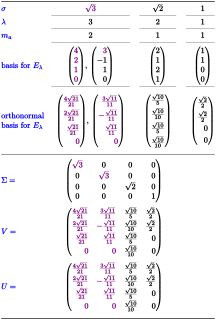

In [24]:
ep_code = E.nm_latex_doc(case='SVD', formater=str, mmS=0, mmLambda=7, fig_scale=0.8) #, color='Indigo')

h = itikz.fetch_or_compile_svg(
        ep_code, prefix='ep_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=1, keep_file="tmp/ep" )
h

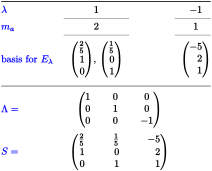

In [25]:
S = sym.Matrix([[1,0,0],[2,1,0],[1,-2,1]])
Q = S.QRdecomposition()[0]
A = 15 * Q @ sym.Matrix([[2,0,0],[0,2,0],[0,0,-2]]) @ Q.transpose()/2

nM.show_eig_tbl(A,Ascale=15)

In [26]:
A

Matrix([
[-10, 10,  5],
[ 10, 11, -2],
[  5, -2, 14]])

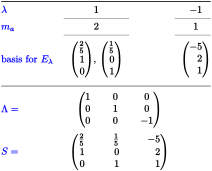

In [27]:
nM.show_eig_tbl(A/15)

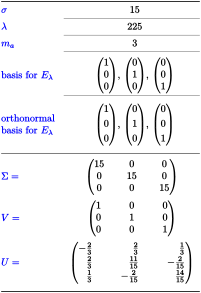

In [28]:
def svd_tbl(A):
    A   = sym.Matrix(A)
    eig = {
        'sigma':  [],
        'lambda': [],
        'ma':     [],
        'evecs':  [],
        'qvecs':  [],
        'uvecs':  []
    }
    def mySVD(A):
        def q_gram_schmidt( v_list ):
            W = []
            for j in range( len( v_list )):
                w_j = v_list[j]
                for k in range( j-1 ):
                    w_j = w_j - W[k].dot( v_list[j]) * W[k]
                W.append(1/w_j.norm() * w_j)
            return W

        def sort_eig_vec(sym_eig_vec):
            sort_eig_vecs = sorted(sym_eig_vec, key=lambda x: x[0], reverse=True)

            for i in sort_eig_vecs:
                sigma = sym.sqrt(i[0])
                eig['sigma'].append(sigma)

                eig['lambda'].append( i[0] )
                eig['ma'].append( i[1] )
                eig['evecs'].append( i[2] )
                vvecs = q_gram_schmidt( i[2] )
                eig['qvecs'].append( vvecs )

                if not sigma.is_zero:
                    eig['uvecs'].append( [ 1/sigma * A * v for v in vvecs] )

        sort_eig_vec((A.T @ A).eigenvects())
        ns = A.T.nullspace()
        if len(ns) > 0:
            ns_on_basis = q_gram_schmidt( ns )
            eig['uvecs'].append( ns_on_basis )

    mySVD(A)
    return nM.EigenProblemTable( eig, formater=sym.latex, sz=A.shape )

def show_svd_table(A, mmS=10, mmLambda=8, fig_scale=0.8, color='blue' ):
    E        = svd_tbl(A)
    display( E.eig)
    svd_code = E.nm_latex_doc( formater=str, case='SVD', mmS=mmS, mmLambda=mmLambda, fig_scale=fig_scale, color=color)
    
    h = itikz.fetch_or_compile_svg(
            svd_code, prefix='svd_', working_dir="tmp", debug=False,
            **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
            nexec=1, keep_file="tmp/svd" )
    return h

S = sym.Matrix([[1,0,0],[2,1,0],[1,-2,1]])
Q = S.QRdecomposition()[0]
A = 15 * Q @ sym.Matrix([[2,0,0],[0,2,0],[0,0,-2]]) @ Q.transpose()/2
nM.show_svd_table(A, tmp_dir='./tmp', keep_file="./tmp/foo")

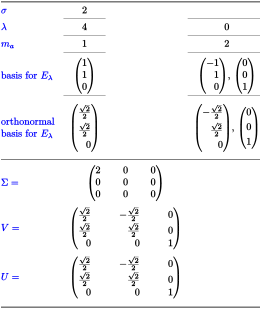

In [29]:
B = np.mat([[1,1,0],[1,1,0],[0,0,0]])
nM.show_svd_table(B, tmp_dir='./tmp', keep_file="./tmp/foo")

In [30]:
#show_svd_table(B)
svd_tbl(B).eig

{'sigma': ['2', '0'],
 'lambda': ['4', '0'],
 'ma': [1, 2],
 'evecs': [[array(['1', '1', '0'], dtype=object)],
  [array(['-1', '1', '0'], dtype=object),
   array(['0', '0', '1'], dtype=object)]],
 'qvecs': [[array(['\\frac{\\sqrt{2}}{2}', '\\frac{\\sqrt{2}}{2}', '0'], dtype=object)],
  [array(['- \\frac{\\sqrt{2}}{2}', '\\frac{\\sqrt{2}}{2}', '0'],
         dtype=object),
   array(['0', '0', '1'], dtype=object)]],
 'uvecs': [[array(['\\frac{\\sqrt{2}}{2}', '\\frac{\\sqrt{2}}{2}', '0'], dtype=object)],
  [array(['- \\frac{\\sqrt{2}}{2}', '\\frac{\\sqrt{2}}{2}', '0'],
         dtype=object),
   array(['0', '0', '1'], dtype=object)]]}

In [31]:
itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True)

{'tex_program': ['latexmk', '-quiet', '-silent', '-xelatex'],
 'svg_converter': [['pdf2svg'], '.pdf'],
 'svg_crop': ['inkscape',
  '--batch-process',
  '--export-plain-svg',
  '-D',
  '--export-margin=1',
  '-o']}

matrix([[1, 1, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 0, 0]])

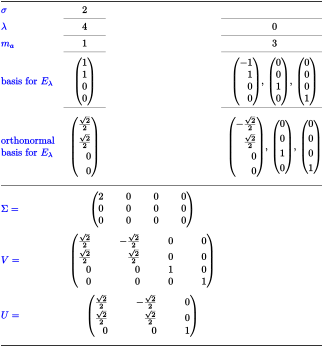

In [32]:
B = np.mat([[1,1,0],[1,1,0],[0,0,0], [0,0,0]]).T
E = svd_tbl(B)
display(B)

nM.show_svd_table(B)

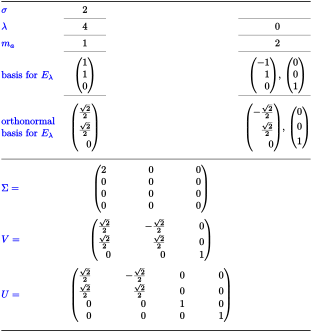

In [33]:
nM.show_svd_table(B.T, mmLambda=15,mmS=12)

# NEW Nicematrix.sty

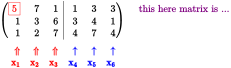

In [34]:
m1 = nM.MatrixGridLayout(gen_matrix(3,6), extra_cols=1, extra_rows=2)
m1.array_format_string_list( partitions={ 1:[3]}, spacer_string=r'@{\hspace{5mm}}' )
m1.array_of_tex_entries()
m1.decorate_tex_entries( 0,1, lambda a: '\\color{{red}}{{ \\boxed{{{a}}} }}'.format(a=a), entries=[(0,0)] )

blue = nM.make_decorator(text_color='blue', bf=True)
red  = nM.make_decorator(text_color='red',  bf=True)

typ = [red(r'\Uparrow'),red(r'\Uparrow'),red(r'\Uparrow'),blue(r'\uparrow'),blue(r'\uparrow'),blue(r'\uparrow')]
var = [red('x_1'),      red('x_2'),      red('x_3'),      blue('x_4'),      blue('x_5'),      blue('x_6')]

m1.add_row_below(0,1,typ, formater=lambda a: a )
m1.add_row_below(0,1,var, offset=1, formater=lambda a: a )

m1.nm_text( ['this here matrix is ...'])
m1.nm_submatrix_locs()
m1.tex_repr( blockseps = r'\noalign{\vskip2mm} ')

m1_code = m1.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        m1_code, prefix='m1_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="tmp/m1" )
h

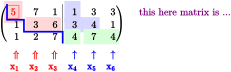

In [35]:
def nm_background(self, gM,gN, loc_list, color='red!15', pt=0):
    '''add background color to a list of entries (has been integrated)'''
    tl,_,_ = self._top_left_bottom_right( gM, gN )
    for entry in loc_list:
        print(entry)

        cmd_1 = f'\\tikz \\node [fill={color}, inner sep = {pt}pt, fit = '
        if not isinstance( entry, list):
            cmd_2  =  f'({tl[0]+entry[0]+1}-{tl[1]+entry[1]+1}-medium)'
        else:
            cmd_2  =  f'({tl[0]+entry[0][0]+1}-{tl[1]+entry[0][1]+1}-medium) ({tl[0]+entry[1][0]+1}-{tl[1]+entry[1][1]+1}-medium)'
        cmd_3 = ' ] {} ;'
        print( '. ', cmd_1 + cmd_2 + cmd_3 )
        self.codebefore.append( cmd_1 + cmd_2 + cmd_3 )

bd = nM.make_decorator( box_color='blue' )
m1.decorate_tex_entries( 0,1, bd,   entries=[(0,1),(1,2)] )

m1.codebefore=[]
m1.nm_background( 0,1, [(0,3), [(1,3),(1,4)]], pt=3, color='blue!15')
m1.nm_background( 0,1, [(2,3), [(2,4),(2,5)]], pt=3, color='green!15')
m1.nm_background( 0,1, [(0,0), [(1,1),(1,2)]], pt=3)

m1.nm_add_rowechelon_path( 0,1, [(0,0), (1,1), (2,3) ],case='vv',color='blue,line width=0.6mm', adj=0)

print()

m1_code = m1.nm_latexdoc()

h = itikz.fetch_or_compile_svg(
        m1_code, prefix='m1_', working_dir="tmp", debug=False,
        **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True),
        nexec=4, keep_file="tmp/m1" )
h

In [36]:
!cat tmp/m1*.tex

\documentclass[notitlepage]{article}
\pagestyle{empty}
\usepackage[margin=0cm,paperwidth=90in]{geometry}

\usepackage{mathtools}
\usepackage{xltxtra}
\usepackage{pdflscape}
\usepackage{graphicx}
\usepackage[table,svgnames]{xcolor}
\usepackage{nicematrix,tikz}
\usetikzlibrary{calc,fit,decorations.markings}

\newcommand*{\colorboxed}{}
\def\colorboxed#1#{%
  \colorboxedAux{#1}%
}
\newcommand*{\colorboxedAux}[3]{%
  % #1: optional argument for color model
  % #2: color specification
  % #3: formula
  \begingroup
    \colorlet{cb@saved}{.}%
    \color#1{#2}%
    \boxed{%
      \color{cb@saved}%
      #3%
    }%
  \endgroup
}

% ---------------------------------------------------------------------------- extension
%

\begin{document}\begin{minipage}{\textwidth}
\begin{landscape}

% ---------------------------------------------------------------------------- preamble

 \NiceMatrixOptions{cell-space-limits = 1pt}
%
% ============================================================================

## Back Substitution Layout

Matrix([
[1,    2,        4,            1],
[0,    1,       -9,           -2],
[0, -2*k, 9*k - 36, h + 2*k - 10]])

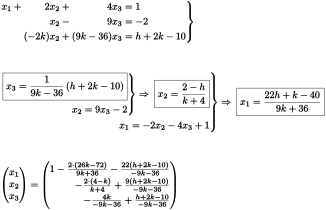

In [37]:
k  = sym.Symbol('k'); h = sym.Symbol('h')
Ab = sym.Matrix([[1,2,4,1],[2,-k,8,h],[3,7,3,1]]); matrices = [[None, Ab]]; pivots = []; txt=[]
# we could use row ops, but we want a computational layout (and hence the E matrices!):
#    A=A.elementary_row_op('n->n+km', k=-3, row1=2,row2=0 );A
#    A=A.elementary_row_op('n<->m',row1=1,row2=2);A

E1=sym.eye(3);E1[1:,0]=[-2,-3]; A1=E1*Ab;                               matrices.append([E1,A1]); pivots.append((1,1));txt.append('Pivot at (1,1)')
E2=sym.eye(3);E2=E2.elementary_row_op('n<->m',row1=1,row2=2); A2=E2*A1; matrices.append([E2,A2]); pivots.append(None); txt.append('Rows 2 <-> 3')
E3=sym.eye(3);E3[2,1]=4-k; A3=E3*A2;                                    matrices.append([E3,A3]); pivots.append((2,2));txt.append('Pivot at (2,2)')
pivots.append((3,3)); txt.append('In Row Echelon Form')
#Ab,A3,pivots
display(A3)
foo = nM.BacksubstitutionCascade.from_ref_Ab( A3 )
foo.show( show_system=True, show_cascade=True, show_solution=True, keep_file="tmp/foo")

matrix([[ 0,  2,  1, -1,  0],
        [ 0,  0,  0, -1,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]])

matrix([[3],
        [1],
        [0],
        [0],
        [0]])

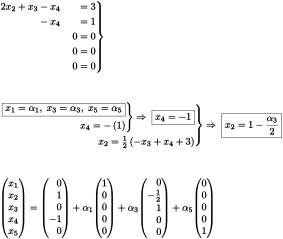

In [39]:
ref_A   = np.matrix([[0,2,1,-1,0],[0,0,0,-1,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
ref_rhs = np.matrix([[3,1,0,0,0]]).T
display(ref_A), display(ref_rhs)
print(); print()

foo = nM.BacksubstitutionCascade( ref_A, ref_rhs )
foo.show( A=foo.ref_A, b = foo.ref_rhs, show_system=True, show_cascade=True, show_solution=True,
          fig_scale=None, keep_file="tmp/foo" )
#print(foo.nm_latex_doc( show_cascade=True, show_solution=True, fig_scale=0.8))

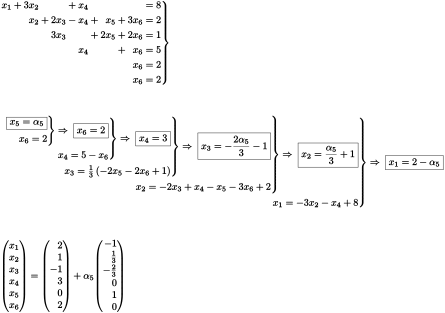

In [40]:
A = np.matrix( [  [ 1, 3, 0,  1, 0, 0],
                  [ 0, 1, 2, -1, 1, 3],
                  [ 0, 0, 3,  0, 2, 2],
                  [ 0, 0, 0,  1, 0, 1],
                  [ 0, 0, 0,  0, 0, 1],
                  [ 0, 0, 0,  0, 0, 1],
               ])
rhs= A @ np.matrix([[ 2, 1, -1, 3, 0, 2]]).T

foo = nM.BacksubstitutionCascade( A, rhs )
foo.show( A=foo.ref_A, b = foo.ref_rhs, show_system=True, show_cascade=True, show_solution=True,
          fig_scale=None, keep_file="tmp/foo" )

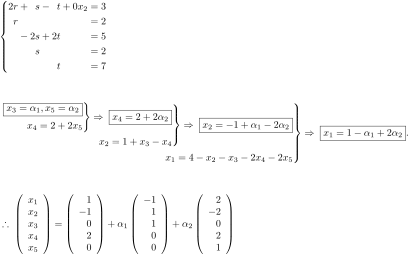

In [42]:
%%itikz --temp-dir  --file-prefix test_  --template article --tex-packages=amssymb,cascade,systeme,nicematrix,tikz,relsize --crop --tikz-libraries=decorations.pathreplacing

\systeme{2r + s -t +0 x_2 = 3, r=2, -2s +2t= 5, s=2, t=7}
\vspace{1cm}

% ==================================================================================== Decorate matrix
    % ------------------------------------------------------------------------------------ Solve
        {\ShortCascade%
           {\ShortCascade%
              {\ShortCascade%
                 {$\boxed{ x_3 = \alpha_1, x_5 = \alpha_2 }$}%
                 {$x_4 = 2 + 2 x_5$}%
                 {$\;\Rightarrow\; \boxed{x_4 =  2 + 2 \alpha_2}$}%
              }%
              {$x_2 = 1 +x_3-x_4$}%
              {$\;\Rightarrow\; \boxed{x_2 = -1+\alpha_1-2\alpha_2}$}%
           }%
           {$x_1 = 4 - x_2 - x_3 - 2 x_4 -2 x_5$}%
           {$\;\Rightarrow \; \boxed{x_1 =  1-\alpha_1+2\alpha_2}.$}
        }%
    %& % --------------------------------------------------------------------------------- Standard Form
    \vspace{1cm}

        {$\; \therefore\;        \left( \begin{array}{r} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \end{array} \right)
                        =        \left( \begin{array}{r}  1  \\  -1 \\   0 \\   2 \\   0 \end{array} \right)
                        + \alpha_1 \left( \begin{array}{r} -1  \\   1 \\   1 \\   0 \\   0 \end{array} \right)
                        + \alpha_2  \left( \begin{array}{r}  2  \\  -2 \\   0 \\   2 \\   1 \end{array} \right)
             $
        }

In [ ]:
!ls tmp

In [43]:
!rm tmp/*